# Using the model to cluster songs according to their genre

### Generate using VAE

In [ ]:
import torch
import torch.nn as nn
import deeplay as dl
import deeptrack as dt
import os

vae = dl.VariationalAutoEncoder(input_size=(512,512),
    latent_dim=50, channels=[32, 64, 128],
).create()


vae.encoder.blocks[0].layer.kernel_size = (5,5)
vae.encoder.blocks[1].layer.kernel_size = (5,5)
vae.encoder.blocks[2].layer.kernel_size = (5,5)
vae.encoder.blocks[3].layer.kernel_size = (5,5)
vae.decoder.blocks[0].layer.kernel_size = (5,5)
vae.decoder.blocks[1].layer.kernel_size = (5,5)
vae.decoder.blocks[2].layer.kernel_size = (5,5)
vae.decoder.blocks[3].layer.kernel_size = (5,5)

vae.load_state_dict(torch.load("vae.pth"))
vae.eval()

#Preprocess data
data_dir = os.path.expanduser("./trainImagesSmall")

#Load image files using ImageFolder
trainFiles = dt.sources.ImageFolder(root=data_dir)

class CropWidth:
    def __init__(self, target_width):
        self.target_width = target_width

    def __call__(self, x: torch.Tensor):
        # assuming input shape [C, H, W]
        return x[..., :self.target_width]
    
image_pip = (dt.LoadImage(trainFiles.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float) >> CropWidth(512))

train_dataset = dt.pytorch.Dataset(image_pip & image_pip, inputs=trainFiles)
train_loader = dl.DataLoader(train_dataset, batch_size=1, shuffle=True)

from Image2Sound import *
from torchvision.utils import save_image
i = 0
for image, _ in train_loader:
    if i == 40:
        import matplotlib.pyplot as plt
        plt.imshow(image.squeeze().squeeze(), aspect='auto', origin='lower', cmap="gray")
        plt.colorbar()
        plt.title("Image before encoding")
        plt.show()
        mu, _ = vae.encode(image)
        image = vae.decode(mu).clone().detach().squeeze(0)
        import matplotlib.pyplot as plt
        plt.imshow(image.squeeze().squeeze(), aspect='auto', origin='lower', cmap="gray")
        plt.colorbar()
        plt.title("Image after decoding")
        plt.show()
        break
    i+=1

"""
latentSpaceImage = vae.encode(img_tensor.unsqueeze(0))
print(latentSpaceImage.shape)
z = 255*torch.stack(latentSpaceImage)
print(z)
"""
#image = image.float()
class conf:
    sampling_rate = 44100
    duration = 6
    samples = sampling_rate * duration
    n_mels = 512
    hop_length = 512
    n_fft = 4096
    fmin = 20
    fmax = sampling_rate // 2

save_image(image, 'test_sample.jpg')
audio = Image2Sound('test_sample.jpg', conf)
SaveAudio(audio,os.getcwd(),"test_sample.mp3")



# Generate using WAE

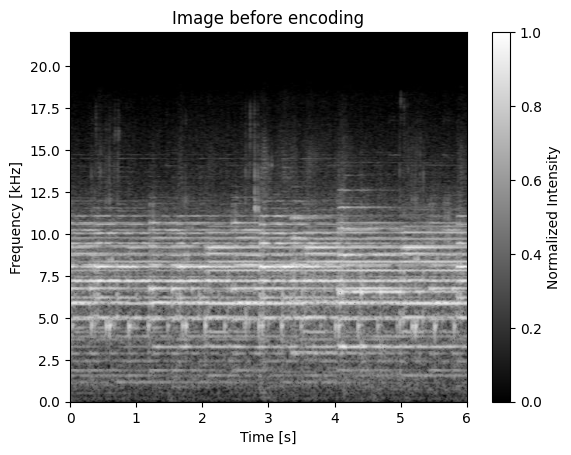

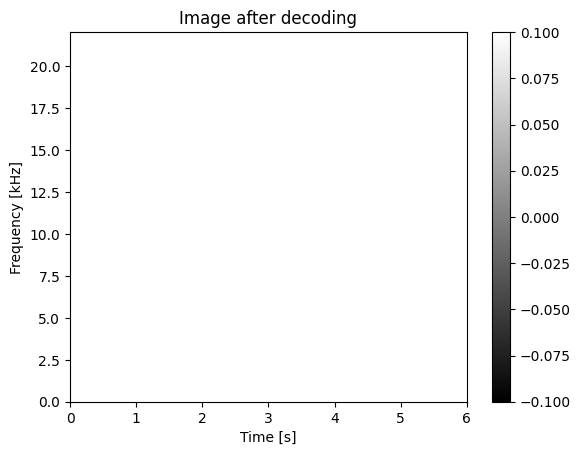

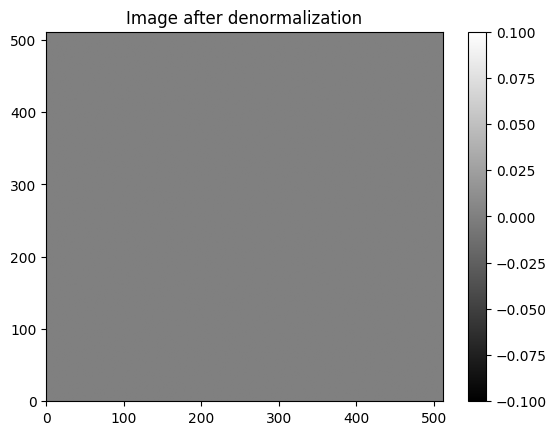

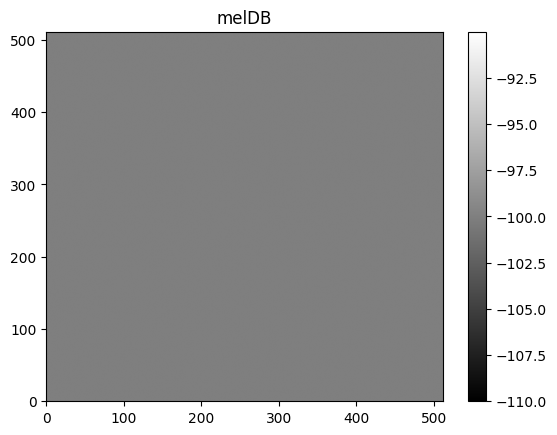

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [3]:
import torch
import torch.nn as nn
import deeplay as dl
import deeptrack as dt
import os

wae = dl.WassersteinAutoEncoder(input_size=[512,512],
    channels=[16, 32, 64, 128, 256], latent_dim=128,
    reconstruction_loss=torch.nn.MSELoss(reduction="mean"), optimizer=dl.AdamW(lr=1e-4)
).create()


wae.load_state_dict(torch.load("wae.pth"))
wae.eval()

#Preprocess data
data_dir = os.path.expanduser("./trainImagesSmall")

#Load image files using ImageFolder
trainFiles = dt.sources.ImageFolder(root=data_dir)

class CropWidth:
    def __init__(self, target_width):
        self.target_width = target_width

    def __call__(self, x: torch.Tensor):
        # assuming input shape [C, H, W]
        return x[..., :self.target_width]
    
image_pip = (dt.LoadImage(trainFiles.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float) >> CropWidth(512))

train_dataset = dt.pytorch.Dataset(image_pip & image_pip, inputs=trainFiles)
train_loader = dl.DataLoader(train_dataset, batch_size=1, shuffle=True)

from Image2Sound import *
from torchvision.utils import save_image
i = 0
for image, _ in train_loader:
    if i == 40:
        import matplotlib.pyplot as plt
        plt.imshow(image.squeeze().squeeze(), aspect='auto', origin='lower', cmap="gray",
                   extent=[0,6,0,22.05])
        cbar = plt.colorbar()
        plt.title("Image before encoding")
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [kHz]")
        cbar.set_label("Normalized Intensity")
        plt.show()
        z = wae.encode(image)
        image = wae.decode(z).clone().detach().squeeze(0)
        import matplotlib.pyplot as plt
        plt.imshow(image.squeeze().squeeze(), aspect='auto', origin='lower', cmap="gray",
                   extent=[0,6,0,22.05])
        plt.colorbar()
        plt.title("Image after decoding")
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [kHz]")
        cbar.set_label("Normalized Intensity")
        plt.show()
        plt.show()
        break
    i+=1


class conf:
    sampling_rate = 44100
    duration = 6
    samples = sampling_rate * duration
    n_mels = 512
    hop_length = 512
    n_fft = 4096
    fmin = 20
    fmax = sampling_rate // 2

save_image(image, 'test_sample.jpg')
audio = Image2Sound('test_sample.jpg', conf)
SaveAudio(audio,os.getcwd(),"test_sample.mp3")